In [8]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

BATCH_SIZE = 10
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/100-bird-species/train',
    labels='inferred',
    #label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/100-bird-species/valid',
    labels='inferred',
    #label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 58388 files belonging to 400 classes.


2022-07-24 13:19:21.359664: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 2000 files belonging to 400 classes.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    # YOUR CODE HERE
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

In [4]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='mse',
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)


In [5]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=10,#50
)

2022-07-24 13:19:22.152691: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
5839/5839 [==============================] - 1378s 236ms/step - loss: 53276.9258 - categorical_accuracy: 1.0000 - val_loss: 52735.4805 - val_categorical_accuracy: 1.0000
Epoch 2/10
5839/5839 [==============================] - 1298s 222ms/step - loss: 53263.8047 - categorical_accuracy: 1.0000 - val_loss: 52735.4805 - val_categorical_accuracy: 1.0000
Epoch 3/10
5839/5839 [==============================] - 1298s 222ms/step - loss: 53263.1172 - categorical_accuracy: 1.0000 - val_loss: 52735.4805 - val_categorical_accuracy: 1.0000
Epoch 4/10
5839/5839 [==============================] - 1295s 222ms/step - loss: 53263.0625 - categorical_accuracy: 1.0000 - val_loss: 52735.4805 - val_categorical_accuracy: 1.0000
Epoch 5/10
5839/5839 [==============================] - 1297s 222ms/step - loss: 53263.0625 - categorical_accuracy: 1.0000 - val_loss: 52735.4805 - val_categorical_accuracy: 1.0000
Epoch 6/10
5839/5839 [==============================] - 1289s 221ms/step - loss: 53263.0508 - c

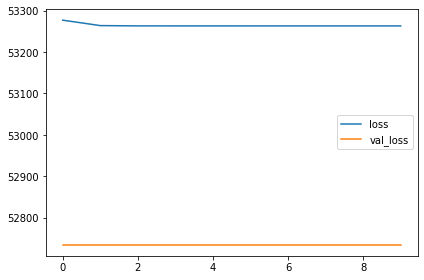

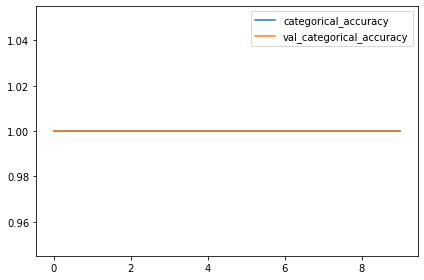

In [6]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

In [7]:
import pathlib
img_height = 128
img_width = 128

sample_path = pathlib.Path("../input/100-bird-species/test/ABBOTTS BOOBY/1.jpg")

class_names = ds_train_.class_names
img = tf.keras.utils.load_img(
    sample_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to ABBOTTS BABBLER with a 100.00 percent confidence.
